In [1]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData
from f1tenth_sim.utils.track_utils import RaceTrack, CentreLine


from f1tenth_sim.data_tools.general_plotting.plot_trajectory_analysis import plot_trajectory_analysis
from f1tenth_sim.data_tools.general_plotting.plot_raceline_tracking import plot_raceline_tracking

from f1tenth_sim.data_tools.plotting_utils import *
from f1tenth_sim.run_scripts.run_functions import *
import numpy as np


if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


## Training Graphs

In [2]:

seeds = [12, 13, 14]
rewards = ["Progress", "CTH", "TAL"]
train_maps = ["mco", "gbr", "esp", "aut"]

total_training_steps = 50000
resampled_xs = np.linspace(0, total_training_steps, 50000)

training_data = {}
for train_map in train_maps:
    for seed in seeds:
        for reward in rewards:
            test_id = f"TD3_{reward}_{seed}_{train_map}"

            root_path = f"Logs/EndToEnd/RawData_{test_id}/"
            results = pd.read_csv(root_path + f"TrainingData_{test_id}.csv")
            steps = results["Steps"]
            progresses = results["Progress"]*100

            resampled_progress = np.interp(resampled_xs, steps, progresses)
            training_data[test_id] = resampled_progress



In [3]:
avg_training_data = {}
min_training_data = {}
max_training_data = {}
downsampled_xs = np.linspace(0, total_training_steps, 1000)
for train_map in train_maps:
    for reward in rewards:
        temp_data = []
        for seed in seeds:
            test_id = f"TD3_{reward}_{seed}_{train_map}"
            temp_data.append(training_data[test_id])
        avg_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_data, axis=0))
        min_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_data, axis=0))
        max_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_data, axis=0))

In [4]:
def true_moving_average_steps(x_data, y_data, period, nxs=1000):
    y_return = np.convolve(y_data, np.ones(period), 'same') / period
    for i in range(period): # start
        t = np.convolve(y_data, np.ones(i+2), 'valid') / (i+2)
        y_return[i] = t[0]
    for i in range(period):
        length = int(round((i + period)/2))
        t = np.convolve(y_data, np.ones(length), 'valid') / length
        y_return[-i-1] = t[-1]
    return y_return



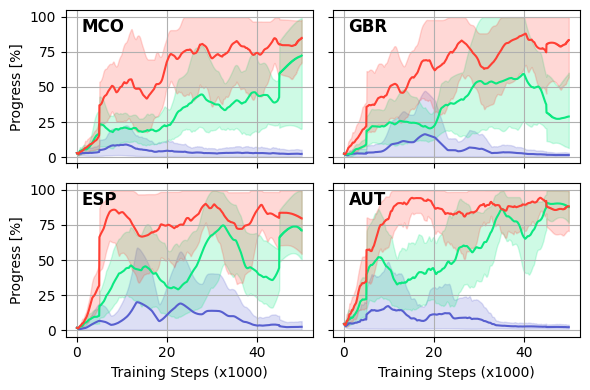

In [5]:

colors = [periwinkle, minty_green, red_orange]
period = 100

fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
for i, train_map in enumerate(train_maps):
    for j, reward in enumerate(rewards):
        ys = avg_training_data[f"{reward}_{train_map}"]
        ys = true_moving_average_steps(downsampled_xs, ys, period, nxs=1000)
        ax[int(i/2), i%2].plot(downsampled_xs/1e3, ys, label=reward, color=colors[j])
        ys_min = true_moving_average_steps(downsampled_xs, min_training_data[f"{reward}_{train_map}"], period, nxs=1000)
        ys_max = true_moving_average_steps(downsampled_xs, max_training_data[f"{reward}_{train_map}"], period, nxs=1000)
        ax[int(i/2), i%2].fill_between(downsampled_xs/1e3, ys_min, ys_max, alpha=0.2, color=colors[j])

    ax[int(i/2), i%2].text(1, 89, f"{train_map.upper()}", fontdict={"fontsize": 12, "fontweight": "bold"})
    ax[1, i%2].set_xlabel("Training Steps (x1000)")
    ax[int(i/2), 0].set_ylabel("Progress [%]")
    # ax[int(i/2), i%2].legend()
    ax[int(i/2), i%2].grid()

plt.tight_layout()

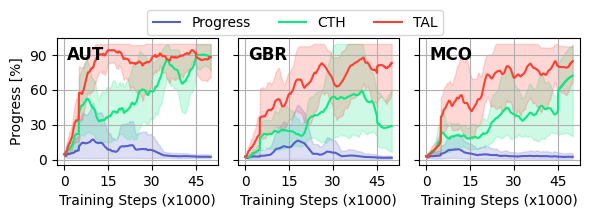

In [70]:

colors = [periwinkle, minty_green, red_orange]
period = 100

plot_maps = ["aut", "gbr", "mco"]
fig, ax = plt.subplots(1, len(plot_maps), figsize=(6, 2), sharex=True, sharey=True)
for i, train_map in enumerate(plot_maps):
    axs = ax[i]
    for j, reward in enumerate(rewards):
        ys = avg_training_data[f"{reward}_{train_map}"]
        ys = true_moving_average_steps(downsampled_xs, ys, period, nxs=1000)
        axs.plot(downsampled_xs/1e3, ys, label=reward, color=colors[j])
        ys_min = true_moving_average_steps(downsampled_xs, min_training_data[f"{reward}_{train_map}"], period, nxs=1000)
        ys_max = true_moving_average_steps(downsampled_xs, max_training_data[f"{reward}_{train_map}"], period, nxs=1000)
        axs.fill_between(downsampled_xs/1e3, ys_min, ys_max, alpha=0.2, color=colors[j])

    axs.text(1, 86, f"{train_map.upper()}", fontdict={"fontsize": 12, "fontweight": "bold"})
    axs.set_xlabel("Training Steps (x1000)")
    axs.grid()
ax[0].set_ylabel("Progress [%]")
ax[0].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[0].xaxis.set_major_locator(plt.MaxNLocator(4))

h, l = ax[0].get_legend_handles_labels()
# fig.legend(h[::2], ["Progress", "CTH", "TAL"], loc="upper center", ncol=3)
# fig.legend(["Progress", "CTH", "TAL"], loc="upper center", ncol=3)
fig.legend(h, ["Progress", "CTH", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.savefig(f"{save_path}BenchmarkProgressTraining.pdf", bbox_inches='tight')
plt.savefig(f"{save_path}BenchmarkProgressTraining.svg", bbox_inches='tight')

In [55]:
summary_df = pd.read_csv("Logs/Summary.csv")

map_list = ["aut", "esp", "gbr", "mco"]

avg_data = {}
min_data = {}
max_data = {}
for i, reward in enumerate(rewards):
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        avg_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()

avg_data = pd.concat(avg_data).reset_index().fillna(0)
avg_data["Reward"] = avg_data["level_0"].apply(lambda x: x.split("_")[0])
avg_data["TrainMap"] = avg_data["level_0"].apply(lambda x: x.split("_")[1])
avg_data = avg_data.drop(columns=["level_0", "StdTime"])
avg_data = avg_data.rename(columns={"MapName": "TestMap"})


# print(avg_data)
avg_data.to_csv("Logs/drl_avg_data.csv", index=False)



Reward TrainMap        CTH  Progress        TAL
0           aut  55.310000  0.706667  72.813333
1           esp  32.020000  1.570000  48.420000
2           gbr  16.746667  1.060000  72.873333
3           mco  47.533333  1.180000  80.303333
Reward TrainMap      CTH  Progress        TAL
0           aut   63.915       0.0  43.896000
1           esp   75.440       0.0  36.424000
2           gbr    0.000       0.0  36.756000
3           mco  120.832       0.0  38.356667


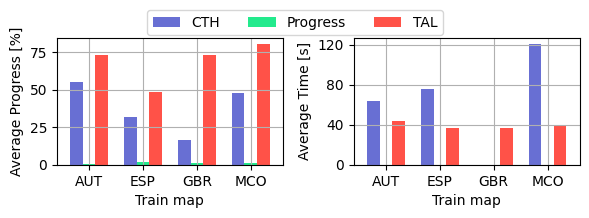

In [74]:

summary_df = pd.read_csv("Logs/drl_avg_data.csv")

fig, ax = plt.subplots(1, 2, figsize=(6, 2.), sharex=True)

xs = np.arange(len(map_list))
width = 0.7
test_map = 'mco'

axs = ax[0]
grouped_df = avg_data.loc[avg_data.TestMap == test_map]
grouped_df = grouped_df[["AvgProgress", "TrainMap", "Reward"]]
grouped_df["AvgProgress"] = grouped_df["AvgProgress"]*100
grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgProgress")
grouped_df = grouped_df.reset_index("TrainMap")
print(grouped_df)
grouped_df.plot.bar(ax=axs, color=colors, width=width, position=1, legend=False, alpha=0.9)

axs.set_xticks(xs - width/2)
axs.set_xticklabels([x.upper() for x in map_list], rotation=0)
axs.set_xlabel(f"Train map")
axs.grid()
axs.set_ylabel("Average Progress [%]")

axs = ax[1]
grouped_df = avg_data.loc[avg_data.TestMap == test_map] 
grouped_df = grouped_df[["AvgTime", "TrainMap", "Reward"]]
grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgTime")
grouped_df = grouped_df.reset_index("TrainMap")
print(grouped_df)
grouped_df.plot.bar(ax=axs, color=colors, width=width, position=1, legend=False, alpha=0.9)


axs.set_xticks(xs - width/2)
axs.yaxis.set_major_locator(plt.MaxNLocator(4))
axs.set_xticklabels([x.upper() for x in map_list], rotation=0)
axs.set_xlabel(f"Train map")
axs.grid()
axs.set_ylabel("Average Time [s]")
fig.legend(["CTH", "Progress", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()

plt.savefig(f"{save_path}BenchmarkArticle_TestResults_{test_map}.pdf", bbox_inches="tight")
plt.savefig(f"{save_path}BenchmarkArticle_TestResults_{test_map}.svg", bbox_inches="tight")

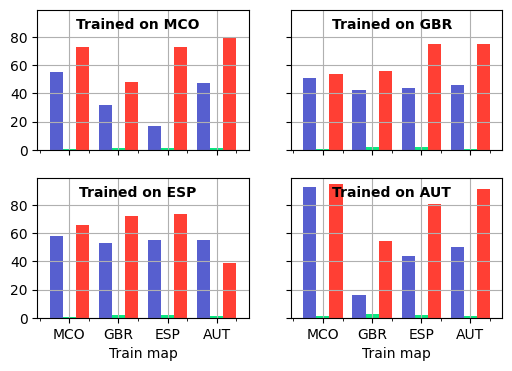

<Figure size 600x400 with 0 Axes>

In [95]:

summary_df = pd.read_csv("Logs/Summary.csv")

map_list = ["aut", "esp", "gbr", "mco"]


avg_data = {}
min_data = {}
max_data = {}
for i, reward in enumerate(rewards):
    # for train_map in map_list:
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        avg_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()
        # min_data[f"{reward}_{train_map}"] = summary_df.groupby("TestID").min()
        # max_data[f"{reward}_{train_map}"] = summary_df.groupby("TestID").max()

avg_data = pd.concat(avg_data).reset_index()
avg_data["Reward"] = avg_data["level_0"].apply(lambda x: x.split("_")[0])
avg_data["TrainMap"] = avg_data["level_0"].apply(lambda x: x.split("_")[1])
# print(avg_data)


fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)

fig = plt.figure(figsize=(6, 4))

xs = np.arange(len(map_list))
width = 0.8
for i, test_map in enumerate(train_maps):
    grouped_df = avg_data.loc[avg_data.MapName == test_map] #.groupby("Reward")
    grouped_df = grouped_df[["AvgProgress", "TrainMap", "Reward"]]
    grouped_df["AvgProgress"] = grouped_df["AvgProgress"]*100
    grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgProgress")
    # print(grouped_df)
    grouped_df = grouped_df.reset_index("TrainMap")
    grouped_df.plot.bar(ax=ax[int(i/2), i%2], color=colors, width=width, position=1, legend=False)

    axs = ax[int(i/2), i%2]
    axs.set_xticks(xs - width/2)
    axs.set_xticklabels([x.upper() for x in train_maps], rotation=0)
    axs.set_xlabel(f"Train map")
    # ax[int(i/2), i%2].set_title(f"{test_map.upper()}")
    axs.text(1, 89, f"Trained on {test_map.upper()}", ha="center", fontdict={"fontsize": 10, "fontweight": "bold"}, va="center")
    axs.grid()

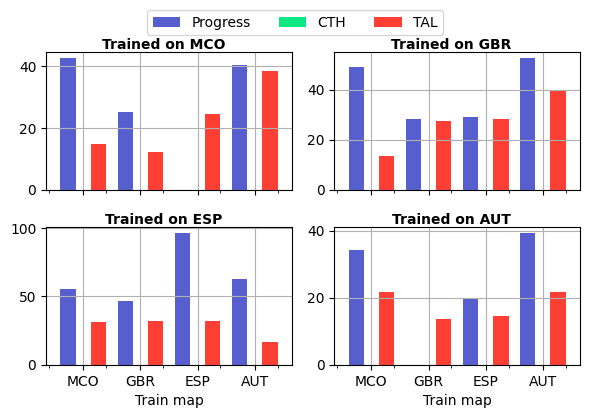

In [108]:

summary_df = pd.read_csv("Logs/Summary.csv").fillna(0)

map_list = ["aut", "esp", "gbr", "mco"]


avg_data = {}
min_data = {}
max_data = {}
for i, reward in enumerate(rewards):
    # for train_map in map_list:
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        avg_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()
        # min_data[f"{reward}_{train_map}"] = summary_df.groupby("TestID").min()
        # max_data[f"{reward}_{train_map}"] = summary_df.groupby("TestID").max()

avg_data = pd.concat(avg_data).reset_index()
avg_data["Reward"] = avg_data["level_0"].apply(lambda x: x.split("_")[0])
avg_data["TrainMap"] = avg_data["level_0"].apply(lambda x: x.split("_")[1])
# print(avg_data)


fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True)


xs = np.arange(len(map_list))
width = 0.8
for i, test_map in enumerate(train_maps):
    grouped_df = avg_data.loc[avg_data.MapName == test_map] #.groupby("Reward")
    grouped_df = grouped_df[["AvgTime", "TrainMap", "Reward"]]
    max_time = grouped_df.AvgTime.max()
    grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgTime")
    # print(grouped_df)
    grouped_df = grouped_df.reset_index("TrainMap")
    grouped_df.plot.bar(ax=ax[int(i/2), i%2], color=colors, width=width, position=1, legend=False)

    ax[int(i/2), i%2].set_xticks(xs - width/2)
    ax[int(i/2), i%2].set_xticklabels([x.upper() for x in train_maps], rotation=0)
    ax[int(i/2), i%2].set_xlabel(f"Train map")
    # ax[int(i/2), i%2].set_title(f"{test_map.upper()}")
    ax[int(i/2), i%2].text(1, max_time * 1.1, f"Trained on {test_map.upper()}", ha="center", fontdict={"fontsize": 10, "fontweight": "bold"}, va="center")
    ax[int(i/2), i%2].grid()

fig.legend(["Progress", "CTH", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()

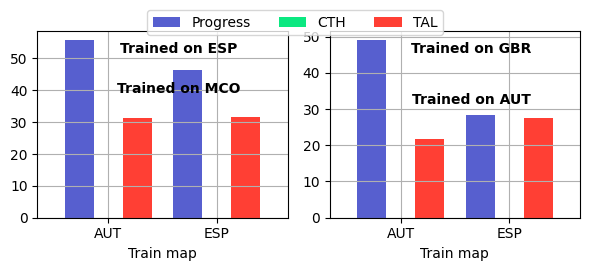

In [120]:

summary_df = pd.read_csv("Logs/Summary.csv").fillna(0)

map_list = ["aut", "esp"]


avg_data = {}
min_data = {}
max_data = {}
for i, reward in enumerate(rewards):
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        avg_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()
        # min_data[f"{reward}_{train_map}"] = summary_df.groupby("TestID").min()
        # max_data[f"{reward}_{train_map}"] = summary_df.groupby("TestID").max()

avg_data = pd.concat(avg_data).reset_index()
avg_data["Reward"] = avg_data["level_0"].apply(lambda x: x.split("_")[0])
avg_data["TrainMap"] = avg_data["level_0"].apply(lambda x: x.split("_")[1])
# print(avg_data)

fig, ax = plt.subplots(1, 2, figsize=(6, 2.6), sharex=True)


xs = np.arange(len(map_list))
width = 0.8
for i, test_map in enumerate(train_maps):
    grouped_df = avg_data.loc[avg_data.MapName == test_map] #.groupby("Reward")
    grouped_df = grouped_df[["AvgTime", "TrainMap", "Reward"]]
    max_time = grouped_df.AvgTime.max()
    grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgTime")
    # print(grouped_df)
    grouped_df = grouped_df.reset_index("TrainMap")
    grouped_df.plot.bar(ax=ax[i%2], color=colors, width=width, position=1, legend=False)

    ax[i%2].set_xticks(xs - width/2)
    ax[i%2].set_xticklabels([x.upper() for x in map_list], rotation=0)
    ax[i%2].set_xlabel(f"Train map")
    # ax[int(i/2), i%2].set_title(f"{test_map.upper()}")
    ax[i%2].text(0.25, max_time * 0.95, f"Trained on {test_map.upper()}", ha="center", fontdict={"fontsize": 10, "fontweight": "bold"}, va="center")
    ax[i%2].grid()

fig.legend(["Progress", "CTH", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()